![alt text](Equations.jpg "Title")

In [1]:
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
import numpy as np
from spatialmath import SE3
from scipy.optimize import minimize

In [2]:
# Import 2-link robot
robot = rtb.models.DH.Planar2()

In [3]:
# Function to perform Inverse kinematics of 2-link robot
def inv_kine(_ee_pos):
    
    # Input:
    # _ee_pos: End effector position in cartesian space (list)
    
    # Output:
    # [_q1, _q2]: Joint angles after inverse kinematics (list)
    
    _x   = _ee_pos[0]
    _y   = _ee_pos[1]
    
    _q2  = np.arccos( (_x**2 + _y**2)/2 - 1 )
    _q1  = np.arctan2(_y, _x) - np.arctan2(np.sin(_q2), 1 + np.cos(_q2))
    
    return [_q1, _q2]

In [4]:
# Loss function definition
def J(_joint_angles):
    
    # Input:
    # _joint_angles: List of joint angles for all time-steps (1 x 42)
    
    # Output:
    # loss: loss value as calculated (scaler)
    
    _dt           = 0.1
    
    _joint_angles = _joint_angles.reshape(2, 21)
    
    _joint_vel = np.diff(_joint_angles) / dt
    _joint_acc = np.diff(_joint_vel) / dt
    
    _ee_pos    = np.zeros((_joint_angles.shape))
    
    for i in range(_joint_angles.shape[1]):
        _ee_pos[:, i] = np.asarray(robot.fkine(_joint_angles[:, i]))[0:2, 3]
    
    _ee_vel    = np.diff(_ee_pos) / dt
    loss       = 0
    
    for i in range(_joint_acc.shape[1]):
        loss  += ( (10 * np.linalg.norm(_joint_acc[:, i])) + (np.linalg.norm(_ee_vel[:, i])) ) * dt
    
    return loss
        

In [5]:
# Define constraints
def set_constraints(_joint_angles):
    
    # Input:
    # _joint_angles: List of joint angles for all time-steps (1 x 42)
    
    # Output:
    # _constraints: Array of all constraints as defined for the optimal control problem
    
    _dt           = 0.1
    _joint_angles = _joint_angles.reshape(2, 21)
    _ee_pos       = np.zeros((_joint_angles.shape))
    
    for i in range(_joint_angles.shape[1]):
        _ee_pos[:, i] = np.asarray(robot.fkine(_joint_angles[:, i]))[0:2, 3]
    
    _ee_vel       = np.diff(_ee_pos) / dt
    
    # Constraint: x(t = 0) = (0.5, 0)
    cons1  = _ee_pos[0,0] - 0.5
    cons2  = _ee_pos[1,0]
    
    # Constraint: x(t = 1) = (0.5, 1)
    cons3  = _ee_pos[0,10] - 0.5
    cons4  = _ee_pos[1,10] - 1
    
    # Constraint: x(t = 2) = (-1, 0.5)
    cons5  = _ee_pos[0,20] + 1 
    cons6  = _ee_pos[1,20] - 0.5
    
    # Constraint: x_dot(t = 1) = (-2, 0)
    cons7  = _ee_vel[0,9] + 2
    cons8  = _ee_vel[1,9]
    
    # Constraint: x_dot(t = 2) = (0, 0)
    cons9  = _ee_vel[0,19]
    cons10 = _ee_vel[1,19]
    
    _constraints = np.array([cons1, cons2, cons3, cons4, cons5, cons6, cons7, cons8, cons9, cons10])
    
    return _constraints
    

In [6]:
# Solver for Optimal Control problem

dt      = 0.1
t       = np.arange(0, 2.1, dt)
n       = len(t)
ee_pos1 = [0.5, 0]
q_pos1  = inv_kine(ee_pos1)

q0       = np.zeros((2, n))
q0[0, :] = q_pos1[0]
q0[1, :] = q_pos1[1]
q0       = q0.flatten()

cons    = ({'type': 'eq', 'fun': lambda var: set_constraints(var)},)

# Set bounds for both the links at all time-steps
bnds    = ((-np.pi, np.pi),)
for i in range(1, len(q0)):
    bnds = bnds + ((-np.pi, np.pi),)

answer = minimize(J, q0, method = 'slsqp', bounds=bnds, constraints = cons, options = {'disp':True, 'ftol':1e-6, 'maxiter':2000})


c:\python38\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization terminated successfully    (Exit mode 0)
            Current function value: 58.78910454492225
            Iterations: 569
            Function evaluations: 24917
            Gradient evaluations: 569


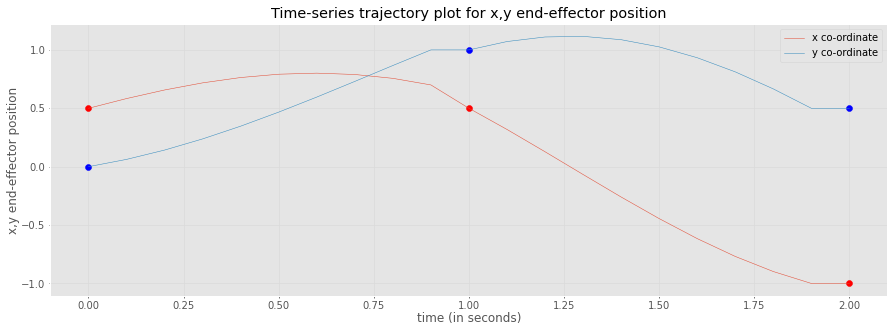

In [19]:
# Time-series trajectory plot for x,y end-effector position
q      = answer.x
q      = q.reshape(2, n)
q      = q.T

ee_pos = np.zeros((q.shape))
    
for i in range(q.shape[0]):
    ee_pos[i, :] = np.asarray(robot.fkine(q[i, :]))[0:2, 3]

# Plot trajectories
plt.plot(t, ee_pos[:, 0])
plt.plot(t, ee_pos[:, 1])

# Plot boundary conditions
plt.scatter(0, 0.5, color = 'r')
plt.scatter(0, 0, color = 'b')
plt.scatter(1, 0.5, color = 'r')
plt.scatter(1, 1, color = 'b')
plt.scatter(2, -1, color = 'r')
plt.scatter(2, 0.5, color = 'b')

plt.xlabel('time (in seconds)')
plt.ylabel('x,y end-effector position')
plt.title('Time-series trajectory plot for x,y end-effector position')
plt.legend(['x co-ordinate', 'y co-ordinate'])

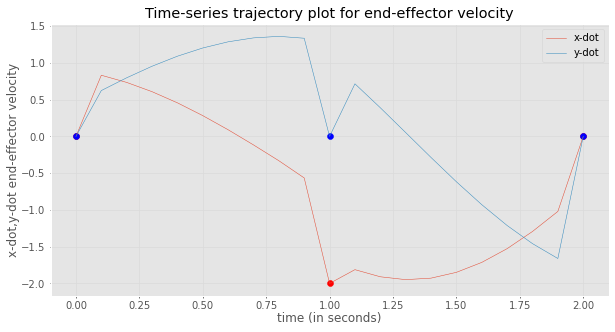

In [20]:
# Time-series trajectory plot for end-effector velocity

ee_vel = np.diff(ee_pos, axis = 0) / dt
ee_vel = np.vstack((np.array([0, 0]), ee_vel))

plt.plot(t, ee_vel[:, 0])
plt.plot(t, ee_vel[:, 1])

# Plot boundary conditions
plt.scatter(0, 0, color = 'r')
plt.scatter(0, 0, color = 'b')
plt.scatter(1, -2, color = 'r')
plt.scatter(1, 0, color = 'b')
plt.scatter(2, 0, color = 'r')
plt.scatter(2, 0, color = 'b')

plt.xlabel('time (in seconds)')
plt.ylabel('x-dot,y-dot end-effector velocity')
plt.title('Time-series trajectory plot for end-effector velocity')
plt.legend(['x-dot', 'y-dot'])

# plt.rcParams['figure.figsize'] = [10, 4]

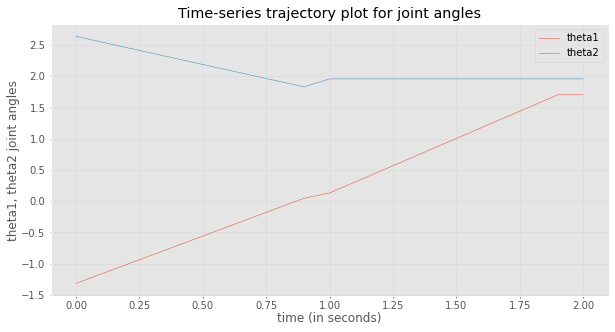

In [21]:
# Time-series trajectory plot for joint angles

# Plot trajectories
plt.plot(t, q[:, 0])
plt.plot(t, q[:, 1])

plt.xlabel('time (in seconds)')
plt.ylabel('theta1, theta2 joint angles')
plt.title('Time-series trajectory plot for joint angles')
plt.legend(['theta1', 'theta2'])

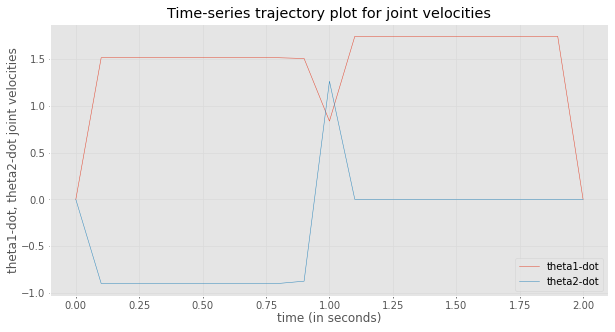

In [22]:
# Time-series trajectory plot for joint velocities

q_dot = np.diff(q, axis = 0) / dt
q_dot = np.vstack((np.array([0, 0]), q_dot))

# Plot trajectories
plt.plot(t, q_dot[:, 0])
plt.plot(t, q_dot[:, 1])

plt.xlabel('time (in seconds)')
plt.ylabel('theta1-dot, theta2-dot joint velocities')
plt.title('Time-series trajectory plot for joint velocities')
plt.legend(['theta1-dot', 'theta2-dot'])

In [11]:
# Create ball trajectory
ball_traj = np.zeros((n, 2))
ball_traj[0, 0] = 2.5
ball_traj[0, 1] = 1

for i in range(1, n):
    
    if i < 11:
        ball_traj[i, 0] = 2.5 - (i * 0.2)
        ball_traj[i, 1] = 1
    
    else:
        ball_traj[i] = ee_pos[i]

# Create gif of the robot catching the ball
for i in range(n):
    fig = plt.figure()

    q1 = q[i]

    # Plot the robot pose
    plot_fig = robot.plot(q=q1, fig=fig, backend = 'pyplot')

    # Add ball to the plot
    plt.scatter(ball_traj[i,0], ball_traj[i,1], color = 'b', s = 64)
    
    # Set plot view to the X-Y axis.
    plot_fig.ax.view_init(90, -90, 0)

    # Set axis limits
    plot_fig.ax.set_xlim(-2, 3)
    plot_fig.ax.set_ylim(-2, 2)

    plt.savefig(str(i) + '.png')
    plt.close(fig)
    
    i += 1